# Scope of the Notebook

1. **Download the breast tumor image dataset from a public web source.**
   - Use the Breast Ultrasound Images (BUSI) dataset.
   - Organize the data into train, validation, and test splits.

2. **Develop and Compare Three Architectures:**
   - A CNN-Transformer hybrid model.
   - A pure Transformer model (DeiT-S).
   - A standard CNN model (ResNet-50).

3. **Train the models using a generic, reusable training function.**
   - Set up data loaders, loss function, optimizer, and training loop.
   - Monitor training and validation accuracy and save the best model.

4. **Evaluate all models on the test dataset using a generic evaluation function.**
   - Calculate accuracy, precision, recall, and F1-score.

5. **Plot the confusion matrix for each model's test predictions.**
   - Visualize and compare model performance across classes.

6. **Summarize findings and discuss potential improvements.**

# 1. Data Loading and Preparation
First, we'll import the necessary libraries, load our dataset, and prepare it for the models.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import timm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1.1. Load Image Paths and Labels

In [2]:
dataset_path = r"Dataset_BUSI_with_GT"
classes = ['malignant', 'normal', 'benign']

images = []
labels = []

for i, cls in enumerate(classes):
    cls_path = os.path.join(dataset_path, cls)
    for fname in os.listdir(cls_path):
        if 'mask' not in fname:
            img_path = os.path.join(cls_path, fname)
            images.append(img_path)
            labels.append(i)
            
print(f"Found {len(images)} images belonging to {len(classes)} classes.")

Found 780 images belonging to 3 classes.


## 1.2. Show Dataset examples

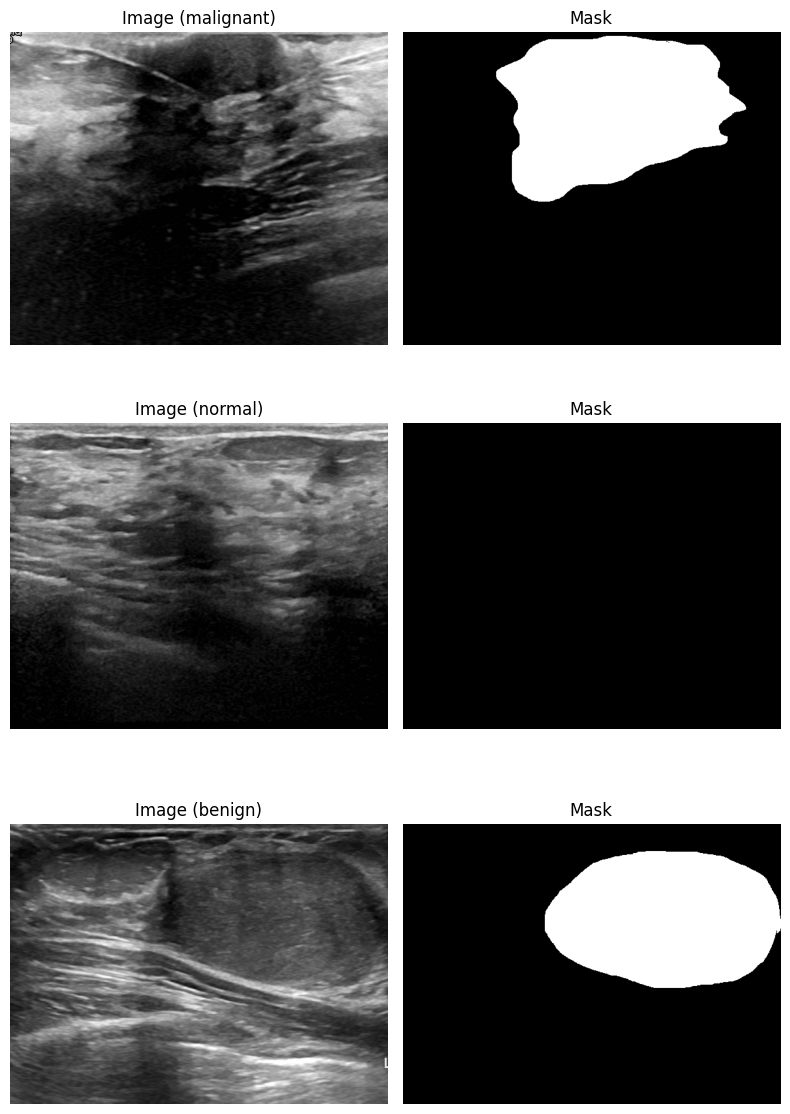

In [25]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12))

for i in range(3):
    # Find a random image for each class
    class_indices = [j for j, label in enumerate(labels) if label == i]
    random_index = random.choice(class_indices)
    
    img_path = images[random_index]
    mask_path = img_path.replace('.png', '_mask.png')
    
    axes[i, 0].imshow(Image.open(img_path), cmap='gray')
    axes[i, 0].set_title(f"Image ({classes[labels[random_index]]})")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(Image.open(mask_path), cmap='gray')
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis('off')
    
plt.tight_layout()
plt.show()

## 1.2. Split Data and Create DataLoaders

In [3]:
# Split data into training, validation, and testing sets (70%, 15%, 15%)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 546
Validation samples: 117
Test samples: 117


## 1.3. Compute Class Weights for Imbalanced Data
To address class imbalance in the training set, we calculate class weights inversely proportional to the frequency of each class. These weights are then used in the loss function (`CrossEntropyLoss`) to penalize misclassification of minority classes more heavily. This helps the models learn more balanced decision boundaries and improves performance, especially for underrepresented classes.


In [16]:
from collections import Counter
import torch

# Count the frequency of each class in the training data
class_counts = Counter(y_train)
total_samples = len(y_train)
num_classes = len(classes)

# Calculate weights for each class (inverse frequency)
# Formula: total_samples / (num_classes * count_of_class)
class_weights = [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)]

# Convert weights to a PyTorch tensor and move it to the active device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class counts in training data: {class_counts}")
print(f"Calculated class weights: {class_weights_tensor}")

# Now, create a weighted CrossEntropyLoss function
# This single criterion can be used for all three models
weighted_criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

Class counts in training data: Counter({2: 306, 0: 147, 1: 93})
Calculated class weights: tensor([1.2381, 1.9570, 0.5948], device='cuda:0')


In [7]:
# Define transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Duplicate channels for pretrained models
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

class BreastCancerDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L') # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create Datasets and DataLoaders
train_dataset = BreastCancerDataset(X_train, y_train, transform=data_transforms['train'])
val_dataset = BreastCancerDataset(X_val, y_val, transform=data_transforms['val'])
test_dataset = BreastCancerDataset(X_test, y_test, transform=data_transforms['val']) # Use val transform for test

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 2. Model Architectures
We define the three models for comparison: a CNN-Transformer Hybrid, a pure Transformer (DeiT-S), and a pure CNN (ResNet-50).

## 2.1. CNN-Transformer Hybrid Model

In [17]:
class CNNTransformerHybrid(nn.Module):
    """
    A CNN-Transformer Hybrid model where the Transformer Encoder is initialized
    with pre-trained weights from DeiT-Small for a more robust baseline.
    """
    def __init__(self, num_classes):
        super(CNNTransformerHybrid, self).__init__()
        
        # 1. Load pre-trained DeiT to get its parameters and encoder
        deit_s = timm.create_model('deit_small_patch16_224', pretrained=True)
        embed_dim = deit_s.embed_dim  # Embed dim for deit_small is 384

        # 2. CNN Backbone (ResNet-50)
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        # Output of ResNet-50 feature extractor is (batch_size, 2048, 7, 7)
        
        # 3. Project CNN feature map to the DeiT's embedding dimension
        self.input_proj = nn.Conv2d(2048, embed_dim, kernel_size=1)
        
        # 4. Use the PRE-TRAINED Transformer Encoder from DeiT
        self.transformer_encoder = deit_s.blocks
        
        # 5. Use the PRE-TRAINED Class Token from DeiT
        self.cls_token = deit_s.cls_token
        
        # 6. Create a new learnable positional embedding for the CNN's output size.
        # The original DeiT pos_embed is for 197 tokens (196 patches + 1 cls), 
        # but our CNN backbone produces 49 patch embeddings. So we create a new one.
        self.pos_embed = nn.Parameter(torch.zeros(1, 49 + 1, embed_dim))
        
        # 7. Classification Head
        # We need a new head for our specific number of classes.
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # CNN Feature Extraction
        x = self.features(x)  # (B, 2048, 7, 7)
        x = self.input_proj(x)  # (B, embed_dim, 7, 7)
        
        # Prepare for Transformer
        x = x.flatten(2).permute(0, 2, 1)  # (B, 49, embed_dim)
        
        # Prepend class token
        batch_size = x.shape[0]
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, 50, embed_dim)
        x = x + self.pos_embed
        
        # Pre-trained Transformer Encoder
        x = self.transformer_encoder(x)  # (B, 50, embed_dim)
        
        # Classification
        cls_token_out = x[:, 0]  # Get the output of the class token
        out = self.fc(cls_token_out)
        return out

## 2.2. DeiT-Small Transformer Model

In [18]:
def get_deit_model(num_classes):
    model = timm.create_model('deit_small_patch16_224', pretrained=True, num_classes=num_classes)
    return model

## 2.3. ResNet-50 CNN Model

In [19]:
def get_resnet_model(num_classes):
    model = models.resnet50(weights='IMAGENET1K_V1')
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

# 3. Generic Training and Evaluation Functions
To avoid code repetition, we define a single training function and a single evaluation function that can be used for all three models.

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, best_model_path, device, desc_prefix=""):
    best_val_acc = 0.0
    print(f"--- Starting Training for {desc_prefix} Model ---")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_corrects = 0
        for inputs, labels in tqdm(train_loader, desc=f"{desc_prefix} Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = train_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"{desc_prefix} Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f'{desc_prefix} Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with validation accuracy: {best_val_acc:.4f}")
    print(f"--- Finished Training for {desc_prefix} Model ---\n")

def evaluate_model(model, test_loader, best_model_path, device, classes, desc_prefix=""):
    print(f"--- Evaluating {desc_prefix} Model ---")
    model.load_state_dict(torch.load(best_model_path))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"{desc_prefix} Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    print(f"\n{desc_prefix} Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{desc_prefix} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("--- Finished Evaluation ---\n")

# 4. Training and Evaluation Execution

In [ ]:
num_epochs = 20
num_classes = len(classes)

## 4.1. Train and Evaluate CNN-Transformer Hybrid Model

--- Starting Training for Hybrid Model ---


Hybrid Epoch 1/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.07it/s]


Hybrid Epoch 1/20 -> Train Loss: 1.1695 Acc: 0.3993 | Val Loss: 0.9554 Acc: 0.3504
New best model saved with validation accuracy: 0.3504


Hybrid Epoch 2/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.19it/s]


Hybrid Epoch 2/20 -> Train Loss: 0.9962 Acc: 0.4634 | Val Loss: 0.7405 Acc: 0.6154
New best model saved with validation accuracy: 0.6154


Hybrid Epoch 3/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.55it/s]


Hybrid Epoch 3/20 -> Train Loss: 0.6719 Acc: 0.7143 | Val Loss: 0.6320 Acc: 0.8034
New best model saved with validation accuracy: 0.8034


Hybrid Epoch 4/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.85it/s]


Hybrid Epoch 4/20 -> Train Loss: 0.6695 Acc: 0.7216 | Val Loss: 0.7894 Acc: 0.7607


Hybrid Epoch 5/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.24it/s]


Hybrid Epoch 5/20 -> Train Loss: 0.5173 Acc: 0.8315 | Val Loss: 0.5188 Acc: 0.8376
New best model saved with validation accuracy: 0.8376


Hybrid Epoch 6/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.26it/s]


Hybrid Epoch 6/20 -> Train Loss: 0.3673 Acc: 0.8626 | Val Loss: 0.7802 Acc: 0.7436


Hybrid Epoch 7/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]


Hybrid Epoch 7/20 -> Train Loss: 0.2928 Acc: 0.9048 | Val Loss: 0.6309 Acc: 0.7350


Hybrid Epoch 8/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.94it/s]


Hybrid Epoch 8/20 -> Train Loss: 0.4071 Acc: 0.8242 | Val Loss: 0.5097 Acc: 0.8547
New best model saved with validation accuracy: 0.8547


Hybrid Epoch 9/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]


Hybrid Epoch 9/20 -> Train Loss: 0.2464 Acc: 0.9011 | Val Loss: 0.3547 Acc: 0.8718
New best model saved with validation accuracy: 0.8718


Hybrid Epoch 10/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]


Hybrid Epoch 10/20 -> Train Loss: 0.2946 Acc: 0.8590 | Val Loss: 0.4942 Acc: 0.8205


Hybrid Epoch 11/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.83it/s]


Hybrid Epoch 11/20 -> Train Loss: 0.4480 Acc: 0.8681 | Val Loss: 0.4644 Acc: 0.8205


Hybrid Epoch 12/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]


Hybrid Epoch 12/20 -> Train Loss: 0.2285 Acc: 0.9176 | Val Loss: 0.4989 Acc: 0.8547


Hybrid Epoch 13/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.69it/s]


Hybrid Epoch 13/20 -> Train Loss: 0.1853 Acc: 0.9267 | Val Loss: 0.5725 Acc: 0.8376


Hybrid Epoch 14/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.06it/s]


Hybrid Epoch 14/20 -> Train Loss: 0.2014 Acc: 0.9194 | Val Loss: 0.4776 Acc: 0.8547


Hybrid Epoch 15/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.42it/s]


Hybrid Epoch 15/20 -> Train Loss: 0.1688 Acc: 0.9451 | Val Loss: 0.5429 Acc: 0.8376


Hybrid Epoch 16/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.98it/s]


Hybrid Epoch 16/20 -> Train Loss: 0.1139 Acc: 0.9560 | Val Loss: 0.7695 Acc: 0.8632


Hybrid Epoch 17/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]


Hybrid Epoch 17/20 -> Train Loss: 0.1459 Acc: 0.9505 | Val Loss: 0.5169 Acc: 0.8718


Hybrid Epoch 18/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]


Hybrid Epoch 18/20 -> Train Loss: 0.1609 Acc: 0.9341 | Val Loss: 0.8375 Acc: 0.7607


Hybrid Epoch 19/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  5.98it/s]


Hybrid Epoch 19/20 -> Train Loss: 0.3329 Acc: 0.8700 | Val Loss: 0.6942 Acc: 0.7778


Hybrid Epoch 20/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.12it/s]


Hybrid Epoch 20/20 -> Train Loss: 0.2829 Acc: 0.9011 | Val Loss: 0.5195 Acc: 0.8718
--- Finished Training for Hybrid Model ---

--- Evaluating Hybrid Model ---


Hybrid Testing: 100%|██████████| 8/8 [00:00<00:00,  8.22it/s]



Hybrid Classification Report:
              precision    recall  f1-score   support

   malignant       0.82      0.84      0.83        32
      normal       0.75      0.90      0.82        20
      benign       0.92      0.85      0.88        65

    accuracy                           0.85       117
   macro avg       0.83      0.86      0.84       117
weighted avg       0.86      0.85      0.86       117



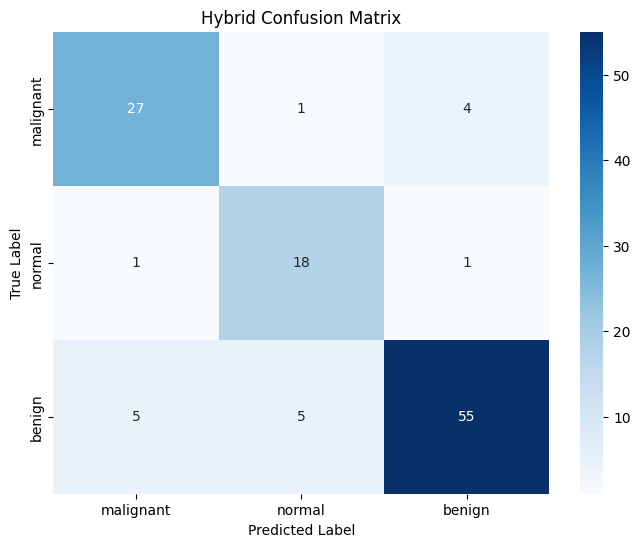

--- Finished Evaluation ---



In [22]:
hybrid_model = CNNTransformerHybrid(num_classes=num_classes).to(device)
optimizer = optim.AdamW(hybrid_model.parameters(), lr=0.0001)
best_hybrid_path = 'best_hybrid_model.pth'

train_model(hybrid_model, train_loader, val_loader, weighted_criterion, optimizer, num_epochs, best_hybrid_path, device, desc_prefix="Hybrid")
evaluate_model(hybrid_model, test_loader, best_hybrid_path, device, classes, desc_prefix="Hybrid")

## 4.2. Train and Evaluate DeiT-S Model

--- Starting Training for DeiT Model ---


DeiT Epoch 1/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.72it/s]


DeiT Epoch 1/20 -> Train Loss: 0.8960 Acc: 0.5495 | Val Loss: 1.0046 Acc: 0.5043
New best model saved with validation accuracy: 0.5043


DeiT Epoch 2/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.87it/s]


DeiT Epoch 2/20 -> Train Loss: 0.6444 Acc: 0.7344 | Val Loss: 0.7897 Acc: 0.7863
New best model saved with validation accuracy: 0.7863


DeiT Epoch 3/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.34it/s]


DeiT Epoch 3/20 -> Train Loss: 0.5442 Acc: 0.7949 | Val Loss: 0.5708 Acc: 0.7436


DeiT Epoch 4/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  9.29it/s]


DeiT Epoch 4/20 -> Train Loss: 0.4035 Acc: 0.8425 | Val Loss: 0.4839 Acc: 0.8120
New best model saved with validation accuracy: 0.8120


DeiT Epoch 5/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]


DeiT Epoch 5/20 -> Train Loss: 0.3152 Acc: 0.8736 | Val Loss: 0.4283 Acc: 0.8376
New best model saved with validation accuracy: 0.8376


DeiT Epoch 6/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.26it/s]


DeiT Epoch 6/20 -> Train Loss: 0.3475 Acc: 0.8535 | Val Loss: 0.4454 Acc: 0.8376


DeiT Epoch 7/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.56it/s]


DeiT Epoch 7/20 -> Train Loss: 0.2094 Acc: 0.9139 | Val Loss: 0.6296 Acc: 0.7265


DeiT Epoch 8/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.72it/s]


DeiT Epoch 8/20 -> Train Loss: 0.2343 Acc: 0.9011 | Val Loss: 0.4084 Acc: 0.8376


DeiT Epoch 9/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.38it/s]


DeiT Epoch 9/20 -> Train Loss: 0.2576 Acc: 0.9011 | Val Loss: 0.6463 Acc: 0.7607


DeiT Epoch 10/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.63it/s]


DeiT Epoch 10/20 -> Train Loss: 0.1880 Acc: 0.9396 | Val Loss: 0.3383 Acc: 0.8547
New best model saved with validation accuracy: 0.8547


DeiT Epoch 11/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.51it/s]


DeiT Epoch 11/20 -> Train Loss: 0.1521 Acc: 0.9432 | Val Loss: 0.6548 Acc: 0.7607


DeiT Epoch 12/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]


DeiT Epoch 12/20 -> Train Loss: 0.1675 Acc: 0.9414 | Val Loss: 0.5091 Acc: 0.8462


DeiT Epoch 13/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  9.08it/s]


DeiT Epoch 13/20 -> Train Loss: 0.0988 Acc: 0.9560 | Val Loss: 0.5411 Acc: 0.8462


DeiT Epoch 14/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  9.13it/s]


DeiT Epoch 14/20 -> Train Loss: 0.1124 Acc: 0.9615 | Val Loss: 0.5759 Acc: 0.8034


DeiT Epoch 15/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  9.67it/s]


DeiT Epoch 15/20 -> Train Loss: 0.1477 Acc: 0.9322 | Val Loss: 0.4491 Acc: 0.8376


DeiT Epoch 16/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]


DeiT Epoch 16/20 -> Train Loss: 0.0754 Acc: 0.9670 | Val Loss: 0.3916 Acc: 0.8718
New best model saved with validation accuracy: 0.8718


DeiT Epoch 17/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  9.72it/s]


DeiT Epoch 17/20 -> Train Loss: 0.1323 Acc: 0.9505 | Val Loss: 0.4508 Acc: 0.8718


DeiT Epoch 18/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  9.64it/s]


DeiT Epoch 18/20 -> Train Loss: 0.1241 Acc: 0.9505 | Val Loss: 0.5205 Acc: 0.8462


DeiT Epoch 19/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  9.31it/s]


DeiT Epoch 19/20 -> Train Loss: 0.0786 Acc: 0.9652 | Val Loss: 0.5766 Acc: 0.7692


DeiT Epoch 20/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.72it/s]


DeiT Epoch 20/20 -> Train Loss: 0.1069 Acc: 0.9542 | Val Loss: 0.5496 Acc: 0.8376
--- Finished Training for DeiT Model ---

--- Evaluating DeiT-S Model ---


DeiT-S Testing: 100%|██████████| 8/8 [00:00<00:00,  9.11it/s]



DeiT-S Classification Report:
              precision    recall  f1-score   support

   malignant       0.78      0.88      0.82        32
      normal       0.81      0.85      0.83        20
      benign       0.88      0.82      0.85        65

    accuracy                           0.84       117
   macro avg       0.82      0.85      0.83       117
weighted avg       0.84      0.84      0.84       117



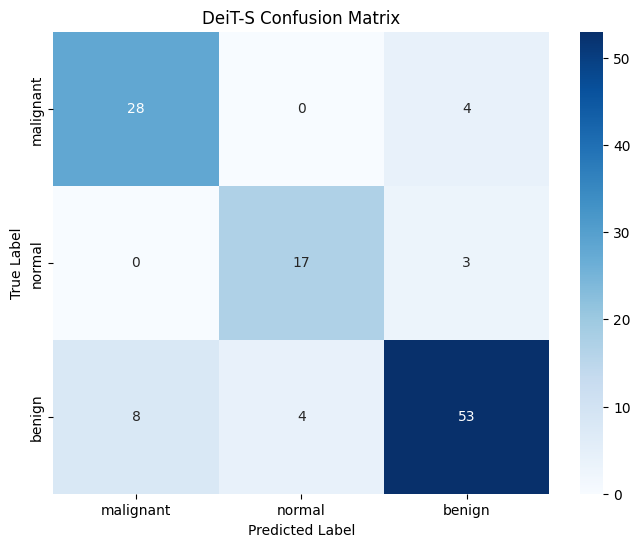

--- Finished Evaluation ---



In [23]:
deit_model = get_deit_model(num_classes=num_classes).to(device)
optimizer = optim.AdamW(deit_model.parameters(), lr=0.0001)
best_deit_path = 'best_deit_model.pth'

train_model(deit_model, train_loader, val_loader, weighted_criterion, optimizer, num_epochs, best_deit_path, device, desc_prefix="DeiT")
evaluate_model(deit_model, test_loader, best_deit_path, device, classes, desc_prefix="DeiT-S")

## 4.3. Train and Evaluate ResNet-50 Model

--- Starting Training for ResNet50 Model ---


ResNet50 Epoch 1/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.23it/s]


ResNet50 Epoch 1/20 -> Train Loss: 0.7330 Acc: 0.6630 | Val Loss: 0.6933 Acc: 0.7521
New best model saved with validation accuracy: 0.7521


ResNet50 Epoch 2/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.44it/s]


ResNet50 Epoch 2/20 -> Train Loss: 0.3598 Acc: 0.8297 | Val Loss: 0.5344 Acc: 0.8120
New best model saved with validation accuracy: 0.8120


ResNet50 Epoch 3/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  6.82it/s]


ResNet50 Epoch 3/20 -> Train Loss: 0.2931 Acc: 0.8864 | Val Loss: 0.4517 Acc: 0.8291
New best model saved with validation accuracy: 0.8291


ResNet50 Epoch 4/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.41it/s]


ResNet50 Epoch 4/20 -> Train Loss: 0.2398 Acc: 0.8974 | Val Loss: 0.5811 Acc: 0.8120


ResNet50 Epoch 5/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  9.60it/s]


ResNet50 Epoch 5/20 -> Train Loss: 0.2435 Acc: 0.9066 | Val Loss: 0.5198 Acc: 0.8889
New best model saved with validation accuracy: 0.8889


ResNet50 Epoch 6/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  9.16it/s]


ResNet50 Epoch 6/20 -> Train Loss: 0.1554 Acc: 0.9469 | Val Loss: 0.3964 Acc: 0.9145
New best model saved with validation accuracy: 0.9145


ResNet50 Epoch 7/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.57it/s]


ResNet50 Epoch 7/20 -> Train Loss: 0.1407 Acc: 0.9505 | Val Loss: 0.6341 Acc: 0.8632


ResNet50 Epoch 8/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.95it/s]


ResNet50 Epoch 8/20 -> Train Loss: 0.1880 Acc: 0.9286 | Val Loss: 0.5765 Acc: 0.8291


ResNet50 Epoch 9/20 [Val]: 100%|██████████| 8/8 [00:01<00:00,  7.79it/s]


ResNet50 Epoch 9/20 -> Train Loss: 0.1007 Acc: 0.9634 | Val Loss: 0.6154 Acc: 0.8205


ResNet50 Epoch 10/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  9.02it/s]


ResNet50 Epoch 10/20 -> Train Loss: 0.1609 Acc: 0.9414 | Val Loss: 0.4714 Acc: 0.8718


ResNet50 Epoch 11/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.78it/s]


ResNet50 Epoch 11/20 -> Train Loss: 0.1892 Acc: 0.9286 | Val Loss: 0.5152 Acc: 0.8547


ResNet50 Epoch 12/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  9.05it/s]


ResNet50 Epoch 12/20 -> Train Loss: 0.1042 Acc: 0.9597 | Val Loss: 0.6174 Acc: 0.8376


ResNet50 Epoch 13/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  9.46it/s]


ResNet50 Epoch 13/20 -> Train Loss: 0.0759 Acc: 0.9689 | Val Loss: 0.5777 Acc: 0.8547


ResNet50 Epoch 14/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.12it/s]


ResNet50 Epoch 14/20 -> Train Loss: 0.0952 Acc: 0.9707 | Val Loss: 0.7264 Acc: 0.8120


ResNet50 Epoch 15/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.73it/s]


ResNet50 Epoch 15/20 -> Train Loss: 0.0642 Acc: 0.9725 | Val Loss: 0.6700 Acc: 0.8632


ResNet50 Epoch 16/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.93it/s]


ResNet50 Epoch 16/20 -> Train Loss: 0.0954 Acc: 0.9579 | Val Loss: 0.6424 Acc: 0.8462


ResNet50 Epoch 17/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  9.43it/s]


ResNet50 Epoch 17/20 -> Train Loss: 0.1222 Acc: 0.9597 | Val Loss: 0.7265 Acc: 0.8803


ResNet50 Epoch 18/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.40it/s]


ResNet50 Epoch 18/20 -> Train Loss: 0.1056 Acc: 0.9652 | Val Loss: 0.7630 Acc: 0.8462


ResNet50 Epoch 19/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.71it/s]


ResNet50 Epoch 19/20 -> Train Loss: 0.1603 Acc: 0.9322 | Val Loss: 0.5303 Acc: 0.8547


ResNet50 Epoch 20/20 [Val]: 100%|██████████| 8/8 [00:00<00:00,  8.64it/s]


ResNet50 Epoch 20/20 -> Train Loss: 0.0806 Acc: 0.9762 | Val Loss: 0.4766 Acc: 0.8632
--- Finished Training for ResNet50 Model ---

--- Evaluating ResNet-50 Model ---


ResNet-50 Testing: 100%|██████████| 8/8 [00:00<00:00,  8.93it/s]



ResNet-50 Classification Report:
              precision    recall  f1-score   support

   malignant       0.85      0.69      0.76        32
      normal       0.86      0.95      0.90        20
      benign       0.84      0.89      0.87        65

    accuracy                           0.85       117
   macro avg       0.85      0.84      0.84       117
weighted avg       0.85      0.85      0.84       117



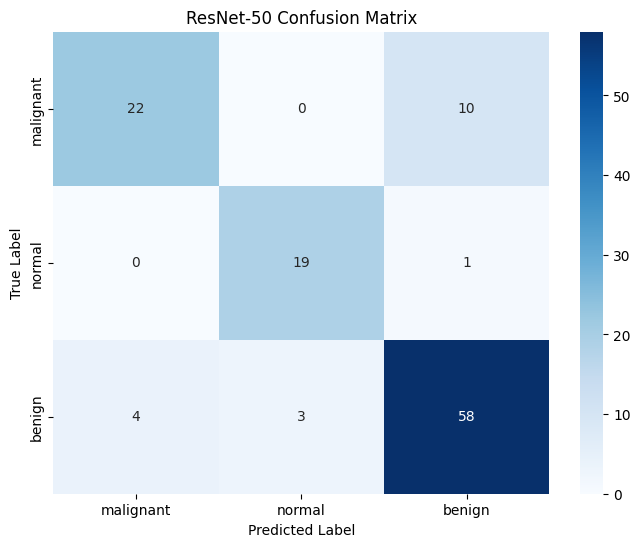

--- Finished Evaluation ---



In [24]:
resnet_model = get_resnet_model(num_classes=num_classes).to(device)
optimizer = optim.AdamW(resnet_model.parameters(), lr=0.0001)
best_resnet_path = 'best_resnet50_model.pth'

train_model(resnet_model, train_loader, val_loader, weighted_criterion, optimizer, num_epochs, best_resnet_path, device, desc_prefix="ResNet50")
evaluate_model(resnet_model, test_loader, best_resnet_path, device, classes, desc_prefix="ResNet-50")

# 5. Summary and Findings

This notebook successfully implemented and compared three different architectures for breast tumor classification: a hybrid CNN-Transformer, a pure DeiT-S transformer, and a pure ResNet-50 CNN.

**Key Steps:**
1. Loaded and preprocessed the BUSI dataset.
2. Implemented all three model architectures using pre-trained weights.
3. Used a single, generic training and evaluation function to ensure a fair and clean comparison.
4. Evaluated all models on the test set, generating classification reports and confusion matrices.

**Potential Improvements:**
* **Hyperparameter Tuning:** Experiment with different learning rates, batch sizes, optimizer settings, and Transformer configurations (e.g., number of heads, layers).
* **Different Backbones:** Try other pre-trained models like EfficientNet or DenseNet to see if they provide better feature extraction for the hybrid model.
* **Longer Training:** Training for more epochs might yield better results, provided overfitting is managed (e.g., with early stopping).